In [96]:
import h5py
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

import matplotlib.pyplot as plt

fpath = "./mps_heis_data.h5"
# https://stackoverflow.com/questions/10988082/multivariate-polynomial-regression-with-numpy

In [18]:
# Read in Matt's data
f = h5py.File(fpath, 'r')

cmt='''
File mps_heis_data.h5 has one array of shape (10121, 50, 4)
- index 1 runs over the 10121 random instances of heisenberg spin-1/2 H's. Each H is of the form
H = \sum_{j, j+1} J_j S_j \dot S_{j+1} + \sum_j h_j S^z_j
	- the couplings J_j are random gaussian variables with mean -1 (antiferromagnetic) and variance 0.1
	- the fields h_j are random gaussian variables with mean 0 and variance 0.1
	- the chain is of length L = 50
- index 2 runs over the physical index {j} of the spin chain
- index 3 labels the stored data as follows:
	- k == 0: vector of the J_j's. This is of size 49 (open boundary conditions) so there is a zero prepended
		e.g. element (100, 29, 0) stores the value of J_{28} which is the coupling between the 28th and 29th qubit
	- k == 1: vector of the h_j's. This is of size 50
	- k == 2: vector of the *uncompressed* bond dimension of the ground state MPS |psi>
	- k == 3: vector of the *compressed* BD of an approximate ground state MPS |phi>

The compressed approximation |phi> satisfies |<phi | psi>| > 1 - 1e-6.

Notes on DMRG:
	- The DRMG algorithm that produced |psi> kept all singular values above 1e-12
	- Convergence was deemed achieved at an additive energy tolerance of 1e-4.
'''

data = f['heis-bd-data'][:,:,:]

In [56]:
# 100 independent variables (99 actually)
# Example, single row of all 100 vars:
# print( data[0,:,0:2].T.flatten() )

# Reorganize the data
indep_var_vals = []
for subarr in data[:,:,0:2] :
#     print(subarr.T.flatten())
    indep_var_vals.append(subarr.T.flatten())
indep_var_vals = np.array(indep_var_vals)
print(indep_var_vals.shape)
Ndat = indep_var_vals.shape[0]

ds_dmrg  = []
ds_compr = []
for subarr in data:
    ds_dmrg.append(subarr[:,2])
    ds_compr.append(subarr[:,3])

ds_dmrg = np.array(ds_dmrg)
ds_compr = np.array(ds_compr)

print(ds_dmrg.shape)
print(ds_compr.shape)

(10121, 100)
(10121, 50)
(10121, 50)


In [91]:
# Polynomial degree
deg_poly = 2
# This is 10,000 independent variables, for a dataset of the same size. Hmm.

# Create polynomial features, and appropriate aux variables
poly = PolynomialFeatures(degree=deg_poly)
X_ = poly.fit_transform(indep_var_vals)



In [49]:
%%time
# Instantiate model
model = linear_model.LinearRegression()
# Fit model (for just one *single* d val)
did = 20
model.fit(X_,ds_dmrg[:,did])


CPU times: user 6min 47s, sys: 10.6 s, total: 6min 58s
Wall time: 1min 10s


LinearRegression()

Remember, we're looking specifically at bond 20
** RMSD: 15.236289966509561
Number of bond sizes predicted to be <= 0: 55 of 10121


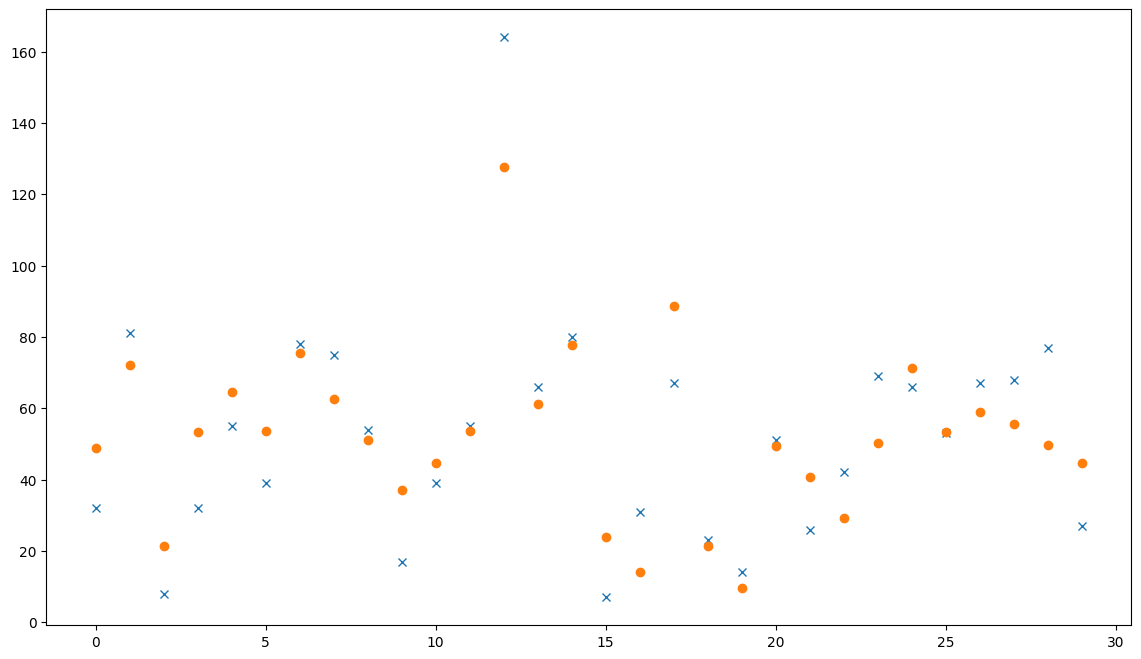

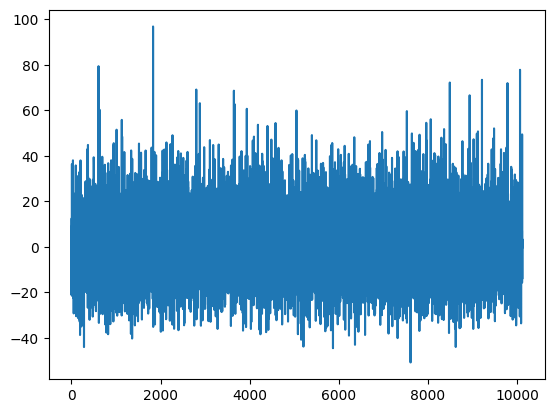

In [97]:
print(f"Remember, we're looking specifically at bond {did}")
# Test model
# r = np.random.randint(Ndat)
# print(f"r: {r}")
predict = indep_var_vals[r,:]
gold = ds_dmrg[:,did]
# print(f"gold: {gold}")

# Run model
Xpredict_ = poly.fit_transform(indep_var_vals)
prediction = model.predict(Xpredict_)

# print(prediction)

plt.figure(figsize=(14,8))
plotlim = 30
plt.plot(gold[:plotlim],'x',label='gold')
plt.plot(prediction[:plotlim],'o',label='model')

rmsd = np.sqrt( ((gold - prediction)**2).mean() )
print(f"** RMSD: {rmsd}")
plt.figure()
plt.plot(gold - prediction)

# Count bonds size 0 or negative
neg_bond_count = (prediction <= 0).sum()
print(f"Number of bond sizes predicted to be <= 0: {neg_bond_count} of {Ndat}")